In [1]:
import os
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot
import multiprocessing
import bulk_case_runner
import earth_model

Particle radii between 0.0116 and 8.61e-06 m


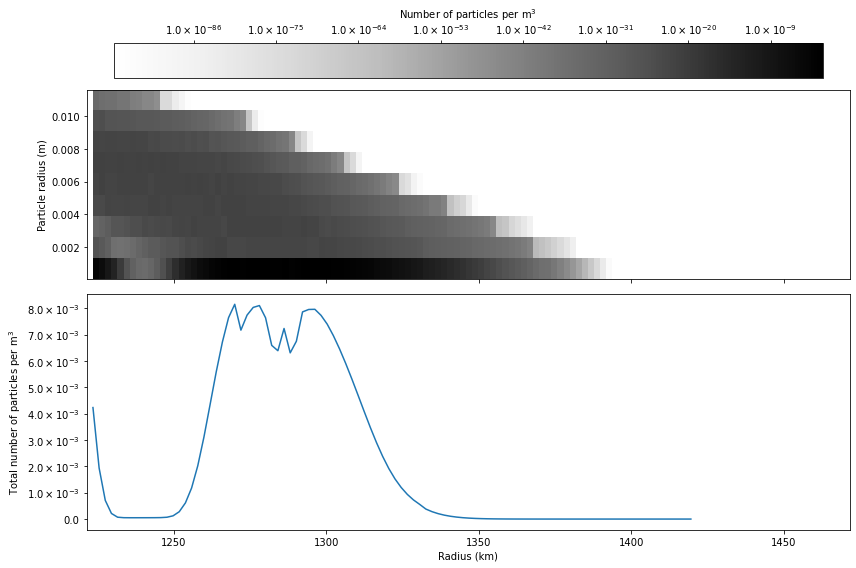

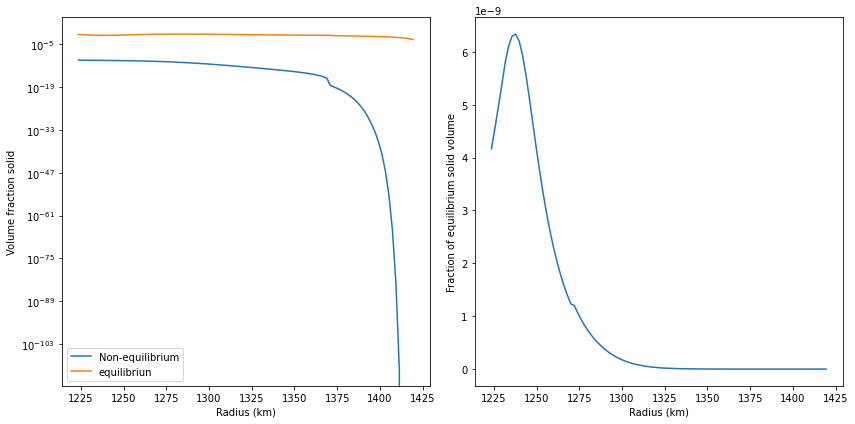

In [2]:
#data = bulk_case_runner.load_case_data('self_consistent.pickle')
#data = bulk_case_runner.load_case_data('optimised.pickle')
#data = bulk_case_runner.load_case_data('optimised_lowt.pickle')
data = bulk_case_runner.load_case_data('optimised_100_knots.pickle')

bulk_case_runner.plot_case_csd_nuc(logscale=True, nonuc=True, **data)
bulk_case_runner.plot_case_solid_frac(**data)

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Temperature at CMB is 4225.944695087244 K
Temperature at top of F-layer is 5676.644650924955 K
Temperature at ICB is 5774.164719317053 K


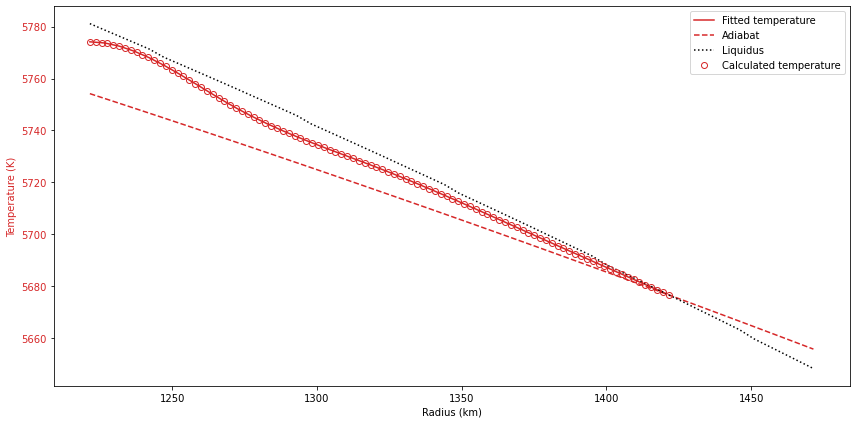

In [3]:
# This is where we set all the F-layer parameters. Quite slow (due to liquidus calc I think)

# F-layer setup
radius_inner_core = data["r_icb"]
f_layer_thickness = data["f_layer_thickness"]
radius_top_flayer = radius_inner_core + f_layer_thickness # 200 km thick.
radius_cmb = data["r_cmb"] # We only need this for setup.
gamma = data["gruneisen_parameter"]

# Check PREM works ... and print some interesting values
prem = earth_model.Prem()
print("Pressure at ICB:", prem.pressure(radius_inner_core/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(radius_top_flayer/1000.0), "GPa")
print("g at ICB:", prem.gravity(radius_inner_core/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(radius_top_flayer/1000.0), "m/s**2")

# Generate the functions for temperautre,
# composition, pressure and gravity
knott_radii = np.linspace(radius_inner_core, radius_top_flayer, data["number_of_knots"])
tfunc, atfunc, ftfunc, tfunc_creator, xfunc, pfunc, \
    gfunc = flayer.setup_flayer_functions(radius_inner_core, radius_cmb, f_layer_thickness, 
                                                    gamma, data["delta_t_icb"], data["xfe_outer_core"],
                                          data["xfe_icb"], knott_radii)

print("Temperature at CMB is", tfunc(radius_cmb), "K")

tfunc = tfunc_creator(data["t_params"])

print("Temperature at top of F-layer is", tfunc(radius_top_flayer), "K")
print("Temperature at ICB is", tfunc(radius_inner_core), "K")

# Interpolate onto radius for plotting
rs = np.linspace(radius_inner_core, radius_inner_core+250.0E3)
ts = tfunc(rs)
ats = atfunc(rs)
ps = pfunc(rs)
xs = xfunc(rs)
# Find the P-X dependent liquidus (storing the temperature at each point)
tl = feot.find_liquidus(xs, ps)

# Plot the F-layer setup alongside the liquidus
fig, ax1 = plt.subplots(figsize=(12,6), tight_layout=True)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs[rs<=radius_top_flayer]/1000.0, ts[rs<=radius_top_flayer], color=color, ls='-', label='Fitted temperature')
ax1.plot(rs/1000.0, ats, color=color, ls='--', label='Adiabat')
ax1.plot(rs/1000.0, tl, color='k', ls=':', label='Liquidus')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])

ax1.plot(data["analysis_radii"]/1000.0, data["out_t_points"], 'o', color=color, fillstyle='none', label='Calculated temperature')

#ax2 = ax1.twinx()  

#color = 'tab:blue'
#ax2.set_ylabel('Pressure (GPs)', color=color)  
#ax2.plot(rs/1000.0, ps, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([280, 330])

ax1.legend()

fig.tight_layout()  
plt.show()



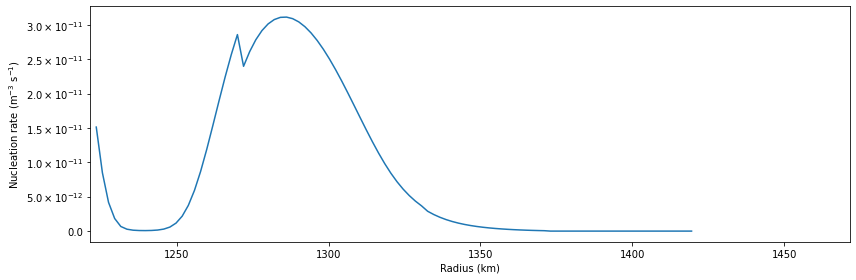

In [4]:
def _sciformat(x, pos=None):
        if x == 0:
            return "0.0"
        scistr = "{:E}".format(x)
        vals = scistr.split('E')
        fmttick = "${:.1f}".format(float(vals[0])) + r"\times 10^{" + "{}".format(int(vals[1])) + "}$"
        return fmttick

fig, ax = plt.subplots(figsize=(12,4), tight_layout=True)
ax.plot(data["analysis_radii"][1:-1]/1000.0, data["nucleation_rates"][1:-1])
ax.yaxis.set_major_formatter(_sciformat)
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Nucleation rate (m$^{-3}$ s$^{-1}$)')
ax.set_xlim(1221.5, 1471.5)
plt.show()